# IMPORT LIBRARIES

In [1]:
!pip install -U scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
cuml 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.


In [2]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from skimage import img_as_float
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing,disk
from skimage.measure import label, regionprops,find_contours
from skimage.morphology import erosion, dilation, opening, closing,disk
import cv2

In [5]:
from tensorflow.keras.applications import MobileNet,VGG19,EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,BatchNormalization,Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential


# LOAD DATA

ChestX-ray14 dataset: https://paperswithcode.com/dataset/chestx-ray14 


CheXpert dataset: https://aimi.stanford.edu/datasets/chexpert-chest-x-rays

In [6]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..','input', 'data','images*', '*', '*.png'))}

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get) #get image path
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png


# VISUALIZATION

In [7]:
# 1 image can have multiple class
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: Finding Labels, Length: 836, dtype: int64

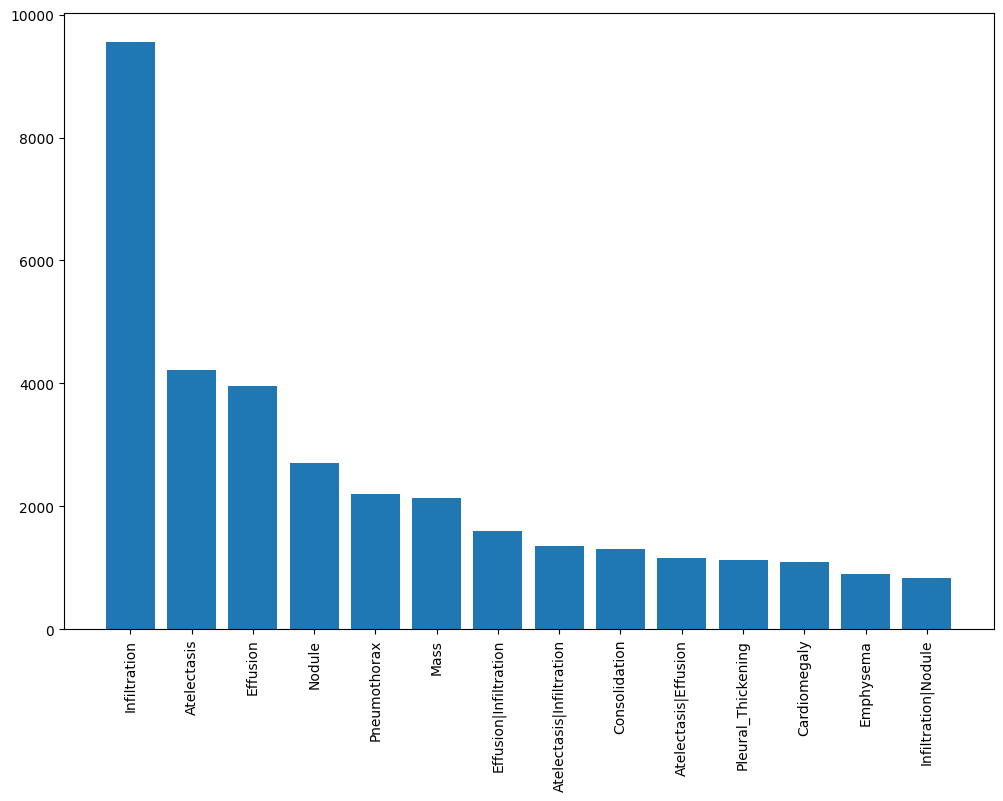

In [8]:
# Top 15 class
label_counts = all_xray_df['Finding Labels'].value_counts()[1:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

=> imbalance dataset

# DATA PROCESSING

## One-hot

In [9]:
all_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# make one-hot
for lb in all_labels:
    all_xray_df[lb] = all_xray_df['Finding Labels'].map(lambda result: 1.0 if lb in result else 0)
all_xray_df.head(20) 


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train test split

In [10]:
# lấy 40000 sample có trọng số
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)


In [11]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 32000 validation 8000


In [15]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
3125,00000823_003.png,Atelectasis|Cardiomegaly|Effusion,3,823,24,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
109108,00029650_002.png,No Finding,2,29650,47,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34539,00009098_000.png,No Finding,0,9098,55,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79251,00019454_000.png,No Finding,0,19454,35,F,PA,2418,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69497,00017138_043.png,Cardiomegaly|Effusion|Infiltration,43,17138,24,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Data Generator

In [12]:
IMAGE_SIZE = 128

In [13]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE_PER_REPLICA = 32

#We obtain the BATCH_SIZE dividing by the number of devices. 
BATCH_SIZE = BATCH_SIZE_PER_REPLICA*strategy.num_replicas_in_sync


In [16]:
core_idg = ImageDataGenerator(horizontal_flip=True,
                             )

In [17]:
train_generator = core_idg.flow_from_dataframe(dataframe=train_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
valid_generator = core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 256)

Found 32000 validated image filenames.
Found 8000 validated image filenames.


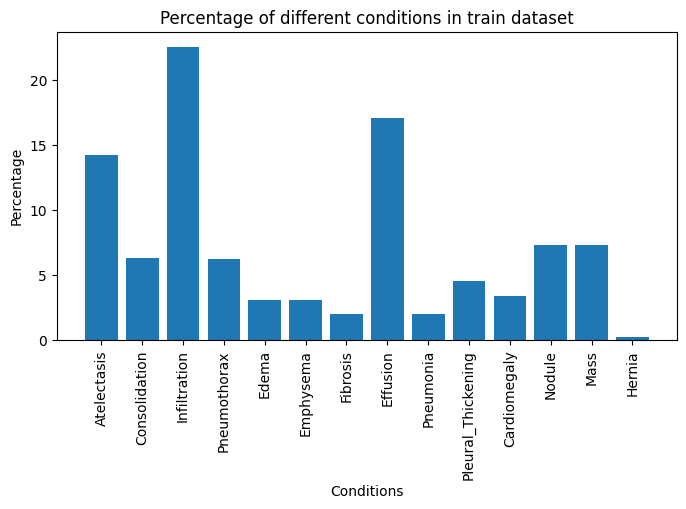

In [18]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(all_labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage of different conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()


## Convert to TF dataset

In [18]:
raw_train_data = tf.data.Dataset.from_generator(
                lambda: train_generator,
                output_types = (tf.float32, tf.float32), 
                output_shapes = ([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))


raw_valid_data = tf.data.Dataset.from_generator(
                lambda: valid_generator,
                output_types=(tf.float32, tf.float32), 
                output_shapes=([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))

In [19]:
raw_train_data

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

In [21]:
one_batch_samples = next(iter(raw_train_data))

In [99]:
image_samples, label_samples = one_batch_samples

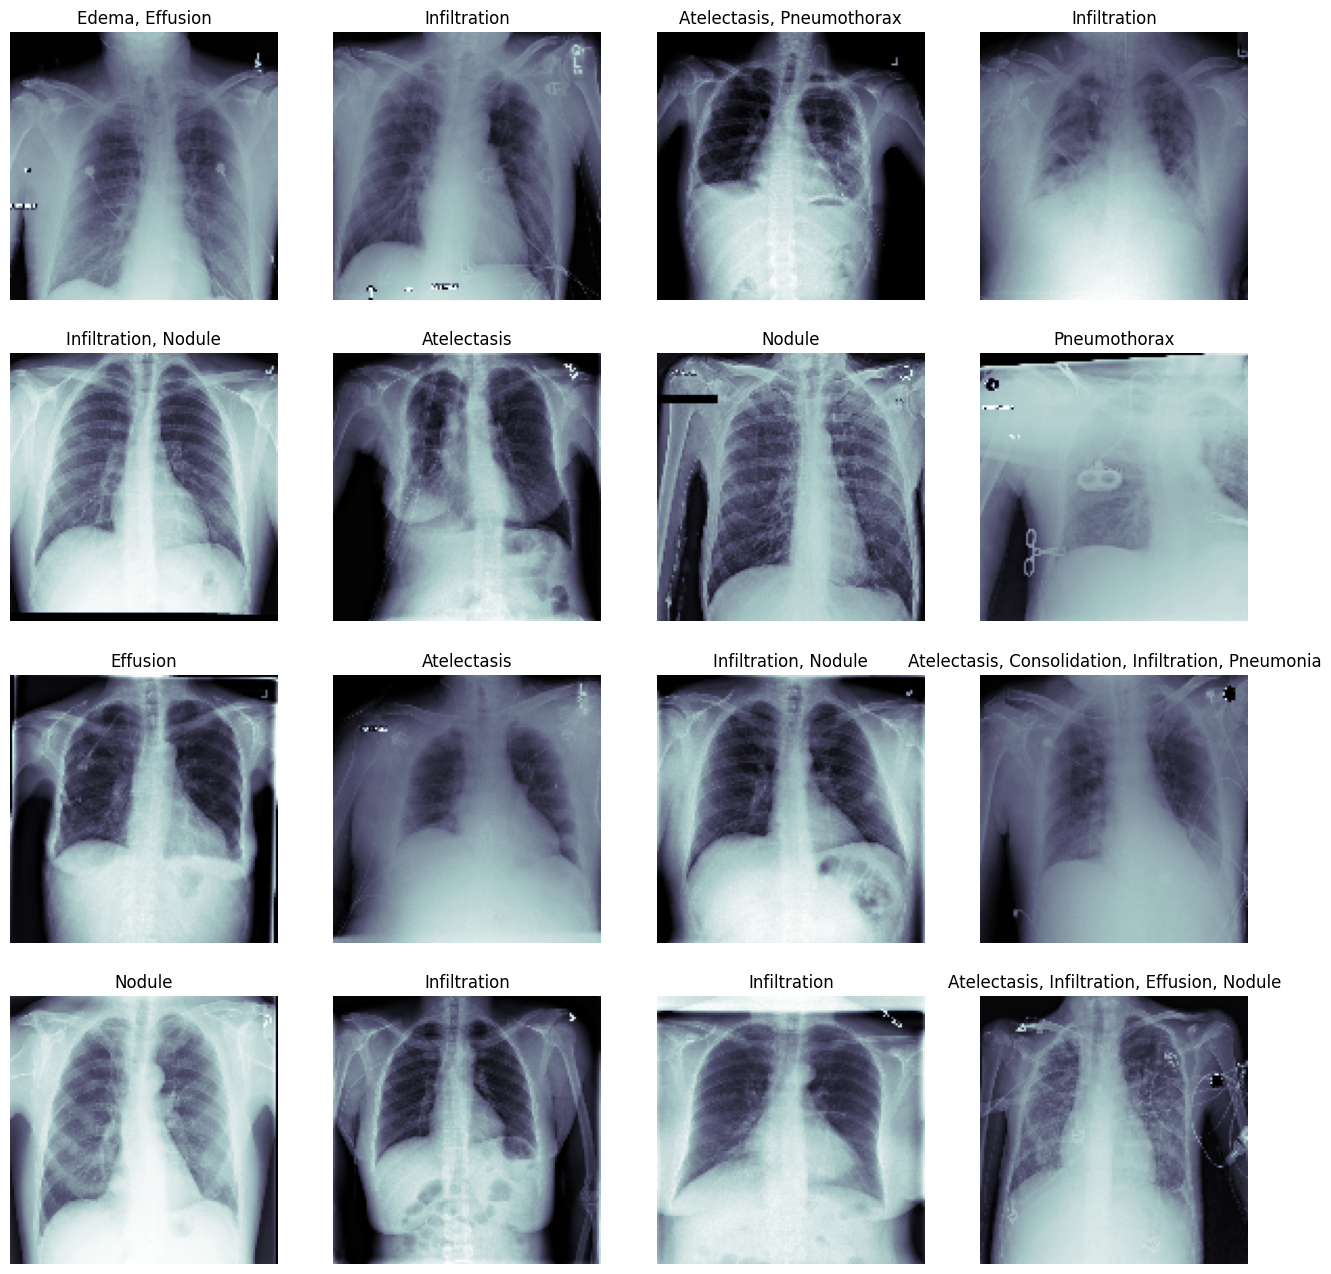

In [117]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
for (img, lb, ax) in zip(image_samples, label_samples, axes.flatten()):
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(all_labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')

## RESCALE

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [21]:
scale_train_data = raw_train_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
scale_valid_data = raw_valid_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)

## BACKGROUND REMOVAL

In [22]:
def background_rm(image):
    
    img_list = []
    for i in range(image.shape[0]):
        try:
            img = image[i]

            sumOfCols = np.sum(img, axis=0)
            sumOfRows = np.sum(img, axis=1)

            for i in range(len(sumOfCols)):
                if sumOfCols[i] > 0:
                    x1 = i
                    break

            for i in range(len(sumOfCols)-1,-1,-1):
                if sumOfCols[i] > 0:
                    x2 = i
                    break

            for i in range(len(sumOfRows)):
                if sumOfRows[i] > 0:
                    y1 = i
                    break

            for i in range(len(sumOfRows)-1,-1,-1):
                if sumOfRows[i] > 0:
                    y2 = i
                    break

            roi = img[y1:y2,x1:x2]
            roi = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE) (roi)
            img_list.append(roi)
        except:
            img_list.append(img)

    return tf.convert_to_tensor(tf.stack(img_list))


In [23]:
def background_rm_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(background_rm, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [24]:
rm_background_train_data = scale_train_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)
rm_background_valid_data = scale_valid_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)

## REMOVE NOISE

In [25]:
def denoise(image):
    return denoise_tv_chambolle(img_as_float(image), weight=0.01)


In [26]:
def denoise_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(denoise, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [27]:
rm_noise_train_data = rm_background_train_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)
rm_noise_valid_data = rm_background_valid_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)

## REMOVE THE DIAPHRAGM REGION

In [28]:
def rmDiapgRegion(image):
    img = img_as_float(image)
    img = np.copy(img)
    # get Diaphragm Region
    
    brightest = img.max()
    darkest = img.min()
#     print(brightest)
    T = darkest + 0.94 * (brightest - darkest)
    binary = img > T

    closed = closing(binary) 
    dilate = dilation(closed)

    # get high density region
    l = label(dilate)
    out = (l==np.bincount(l.ravel())[1:].argmax()+1).astype(np.int64)

    # smoothing region
#     opened = closing(out)
    img[out.astype(np.float32) == 1.0] = 0
        
    return img


In [29]:
def rmDiapgRegion_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(rmDiapgRegion, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [30]:
rm_diapg_train_data = rm_noise_train_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)
rm_diapg_valid_data = rm_noise_valid_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)

In [31]:
rm_diapg_train_data

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

In [32]:
# for image,l in rm_diapg_train_data.take(1):
#     plt.imshow(image[3],cmap = 'bone')

## CONTRAST ENRICHMENT


In [33]:
def contrast_enrich(image):
    return exposure.equalize_adapthist(img_as_float(image),clip_limit = 0.02)
        

In [34]:
def contrast_enrich_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(contrast_enrich, [image,], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [35]:
enhance_contrast_train_data = rm_diapg_train_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)
enhance_contrast_valid_data = rm_diapg_valid_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)


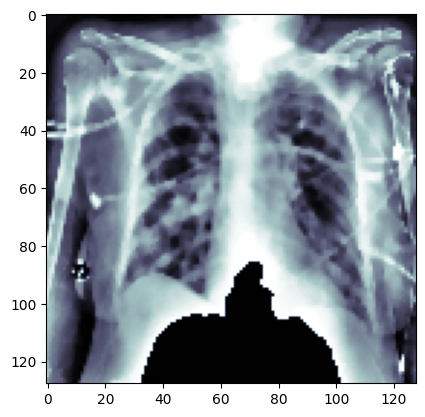

In [132]:
# input image
for image,l in enhance_contrast_train_data.take(1):
    plt.imshow(image[1],cmap = 'bone')

## LUNG SEGMENTATION

A segmentation-based cropped. This function will encourage model to focus on the lungs

In [37]:
inputs = Input((IMAGE_SIZE,IMAGE_SIZE,1))
input_resize = tf.keras.layers.Resizing(512,512, name = 'resize_input') (inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_resize)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [134]:
model.load_weights("/kaggle/input/unet-lung-segmentation-weights-for-chest-x-rays/cxr_reg_weights.best.hdf5")

In [204]:
def lung_segment(image):
    pred = model.predict(image,verbose = 0) > 0.4
    pred = pred.astype(np.int32) # 512,512
    img_list = []
    
    for i in range(image.shape[0]):
        l = label(pred[i])
        z = np.argpartition(np.bincount(l.ravel())[1:],-2)

        out_1 = (l== z[-2] +1).astype(int)
        out_2 = (l== z[-1] +1).astype(int)
        combine = out_1 + out_2
        combine = tf.squeeze(combine)    

        minc_local, maxc_local = 1000,0
        
        label_image = label(combine)
        regions = regionprops(label_image)

        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            if minc_local > minc:
                minc_local = minc
            if maxc_local < maxc:
                maxc_local = maxc

#         if maxc_local - minc_local <= 200 or maxc_local - minc_local >= 300:
#             img_list.append(image[i])
#             continue
        img = tf.keras.layers.Resizing(512,512) (image[i])
        if minc_local - 20 >=0:
            minc_local -= 20
        if maxc_local + 20 <= img.shape[0]:
            maxc_local += 20
        z = img[:,minc_local:maxc_local]
        z = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE,interpolation = "area") (z)
        img_list.append(z)

    return tf.convert_to_tensor(tf.stack(img_list))

In [191]:
def lung_segment_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(lung_segment, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [192]:
lung_segment_train_data = enhance_contrast_train_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)
lung_segment_valid_data = enhance_contrast_valid_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)


In [216]:
def plot_lung_segment_img(image_sample):
    test_img = tf.expand_dims(image_sample,0)
    test_img /= 255.
    test_img = contrast_enrich(test_img)
    test_img = lung_segment(test_img)[0] # it return batchsize,_,_
    
    fig,axes = plt.subplots(1,2,figsize = (15,15))
    axes[0].imshow(image_sample,cmap = 'bone')
    axes[0].set_title("Original Image")
    
    axes[1].imshow(test_img,cmap = 'bone')
    axes[1].set_title("Segmentation-based cropped")


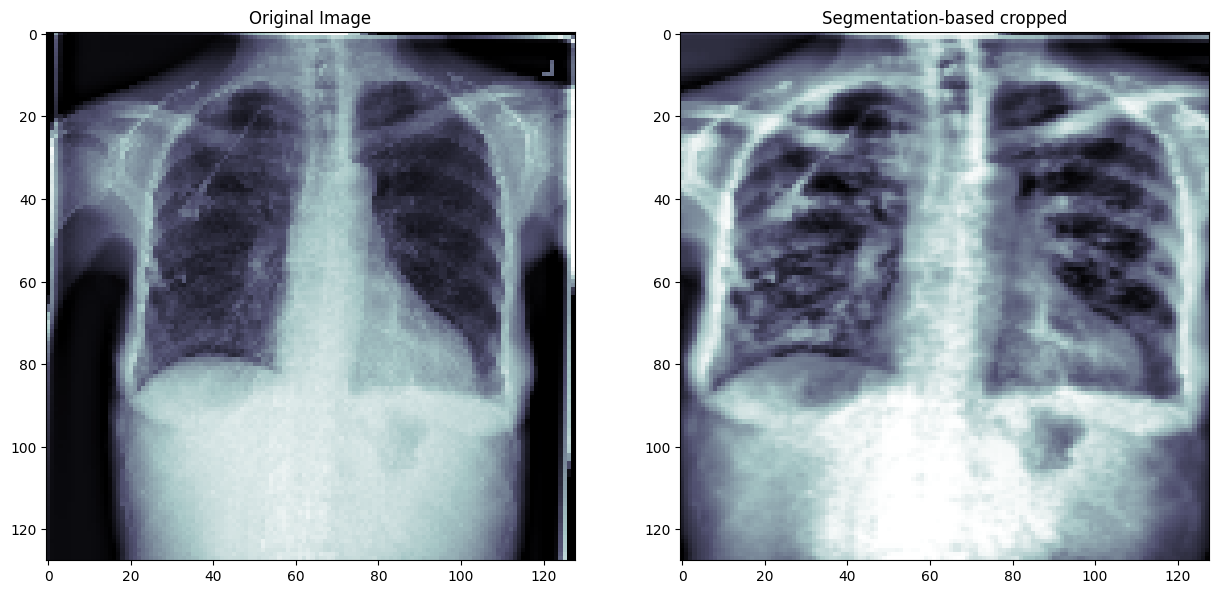

In [217]:
plot_lung_segment_img(image_samples[8])

# MODEL

In [37]:
train_data = scale_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
valid_data = scale_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

In [38]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 1024))


Found 8000 validated image filenames.


In [39]:
test_X_normal = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normal = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normal))

In [60]:
test_X_process = test_X.copy()

test_X_process = background_rm(test_X_process)
test_X_process = tf.keras.layers.Rescaling(1./255) (test_X_process)
test_X_process = denoise(test_X_process)
test_X = rmDiapgRegion(test_X)
test_X_process = contrast_enrich(test_X_process)
# test_X = lung_segment(test_X) #use this will degrade performance
test_X_process = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_process))

## DENSE121

In [42]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

dense121 = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",pooling='avg')
dense121 = dense121(input,)

output = Dense(len(all_labels), activation = 'sigmoid') (dense121)

dense121_model = tf.keras.Model(inputs=[input], outputs=[output])
dense121_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 14)                14350     
                                                                 
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [33]:
dense121_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [30]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [31]:
dense121_model.load_weights("/kaggle/input/vgg19h5/dense121_normal.h5")

In [34]:
dense121_model.fit(train_data, 
            steps_per_epoch = 750,
#           validation_data = valid_data, 
            epochs = 1, 
            verbose = 1,
          )

750/750 [==============================] - 588s 705ms/step - loss: 0.2246 - binary_accuracy: 0.9293 - auc_1: 0.7625


In [ ]:
# dense121_model.save_weights("dense121_normal_.h5")

### NORMAL

In [41]:
y_pred_dense121_normal = dense121_model.predict(test_X_normal)
y_pred_dense121_normal[:5]


32/32 [==============================] - 3s 33ms/step


array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        2.15414797e-37, 0.00000000e+00, 1.04288185e-16, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.85463142e-01, 8.80869806e-01, 3.20916474e-01, 5.63968683e-07,
        3.58179510e-02, 1.17100582e-01, 1.00877909e-02, 9.43163216e-01,
        8.07393633e-04, 4.93532280e-05, 1.16620921e-02, 7.18502048e-03,
        9.11236100e-04, 3.72382073e-12],
       [1.00000000e+00, 1.00000000e+00, 9.99952555e-01, 0.00000000e+00,
        9.99999881e-01, 9.99922395e-01, 7.15092599e-25, 1.00000000e+00,
        7.11006197e-20, 0.00000000e+00, 5.25974730e-09, 5.36876545e-25,
        7.42944121e-31, 0.00000000e+00],
       [5.97058356e-01, 9.19486433e-02, 1.80216283e-01, 4.86246943e-02,
        1.20575838e-02, 3.09031308e-02, 1.82753563e-01, 6.94950223e-01,
        1.54247833e-02, 2.26147138e-02, 7.59216025e-02, 1.91244185e-01,
        9.495

0.4938190742712378


Text(0, 0.5, 'True Positive Rate')

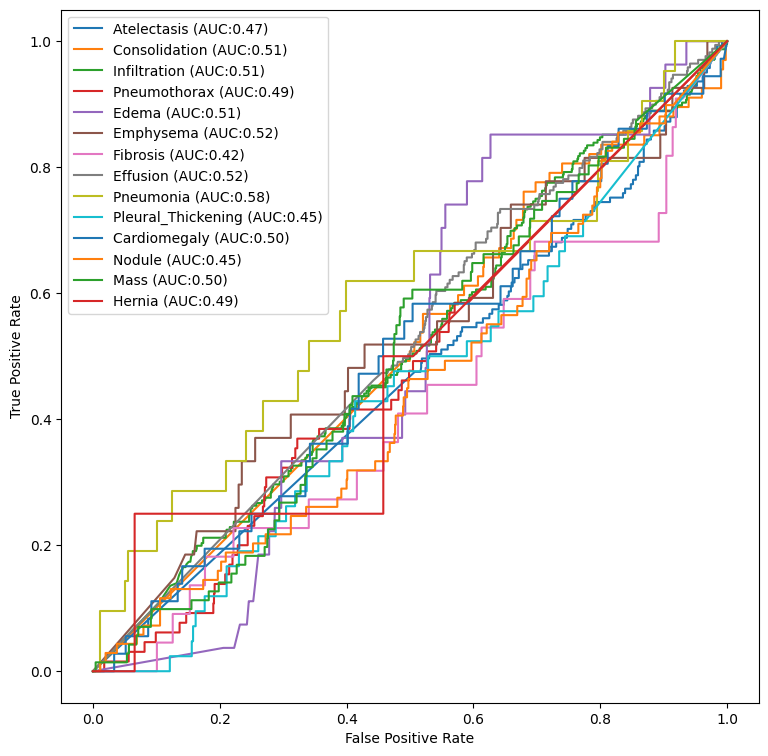

In [43]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_normal += auc(fpr, tpr)

mean_auc_dense121_normal /= 14
print(mean_auc_dense121_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [70]:
dense121_model.load_weights("/kaggle/input/vgg19h5/dense121_3.h5")

In [71]:
y_pred_dense121_preprocess = dense121_model.predict(test_X_process)
y_pred_dense121_preprocess[:5]


32/32 [==============================] - 1s 20ms/step


array([[7.36212432e-02, 3.26708443e-02, 2.49351516e-01, 1.05171399e-02,
        7.39041492e-02, 6.03611721e-03, 6.46247668e-03, 1.30568907e-01,
        1.30411573e-02, 1.90056749e-02, 1.41037256e-01, 1.82449613e-02,
        2.35847067e-02, 1.85664801e-03],
       [7.14776590e-02, 2.57880129e-02, 1.19440429e-01, 1.49793684e-01,
        4.72809514e-03, 2.73687188e-02, 2.53760051e-02, 5.54205813e-02,
        9.55689792e-03, 6.26277849e-02, 1.40522849e-02, 4.62139547e-02,
        3.58145349e-02, 5.79124549e-03],
       [2.93734409e-02, 1.59176737e-01, 5.93410075e-01, 2.38307621e-02,
        2.92127639e-01, 6.76367758e-03, 3.38185206e-03, 7.09666610e-02,
        5.28928861e-02, 1.06968759e-02, 2.47186776e-02, 5.82491755e-02,
        3.04565113e-02, 2.54039362e-04],
       [8.27642083e-02, 2.77956594e-02, 1.82140827e-01, 2.37840917e-02,
        3.85326669e-02, 1.24981655e-02, 2.00822614e-02, 1.41086102e-01,
        1.59721561e-02, 2.91741043e-02, 7.28644907e-01, 3.32820341e-02,
        2.100

0.5546052776089535


Text(0, 0.5, 'True Positive Rate')

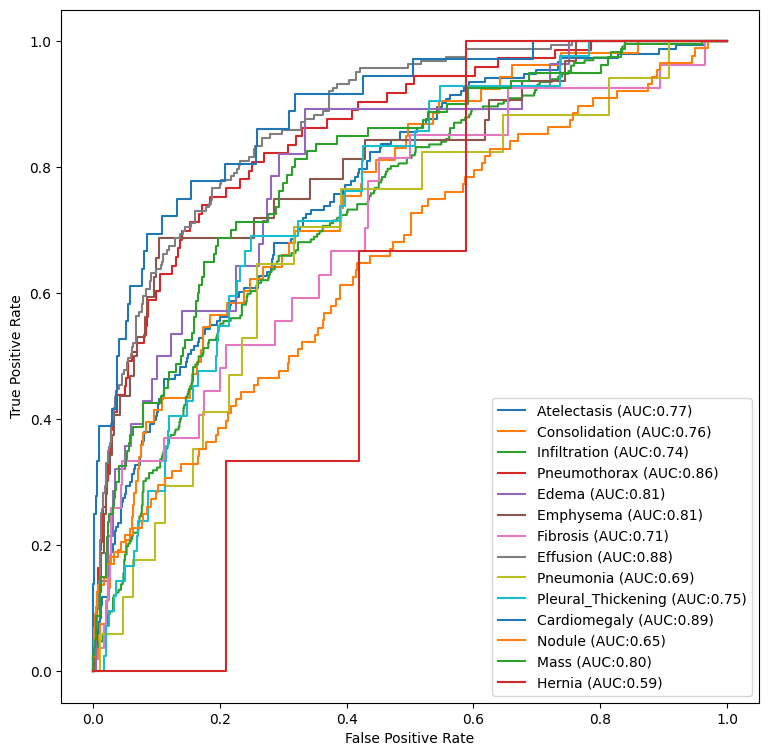

In [74]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_dense121_preprocess = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_dense121_preprocess[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_dense121_preprocess += auc(fpr, tpr)

mean_auc_dense121_preprocess /= 14
print(mean_auc_dense121_preprocess)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## VGG19

In [224]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)
processed_input = tf.keras.applications.vgg19.preprocess_input(input)

vgg19 = VGG19(include_top = False,weights = 'imagenet') 
vgg19 = vgg19(input)

normal = BatchNormalization() (vgg19)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

vgg19_model = tf.keras.Model(inputs=[input], outputs=[output])
vgg19_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                            

In [ ]:
# vgg19_model.load_weights("/kaggle/input/vgg19h5/vgg19_process_lung_2.h5")

In [ ]:
vgg19_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [225]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [ ]:
# vgg19_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [274]:
vgg19_model.load_weights("/kaggle/input/weights/vgg19_no2.h5")

In [275]:
y_pred_vgg19_normal = vgg19_model.predict(test_X_normal)
y_pred_vgg19_normal[:5]

32/32 [==============================] - 1s 36ms/step


array([[8.2584105e-02, 3.7881814e-02, 3.0019498e-01, 6.8092003e-02,
        3.7686486e-02, 2.6229238e-02, 1.5438542e-03, 1.5754566e-01,
        9.7901886e-03, 4.2493615e-02, 1.5515544e-02, 2.5686340e-02,
        3.2223448e-02, 6.1462059e-05],
       [7.9879493e-02, 2.7099514e-02, 2.6999038e-01, 8.0792271e-02,
        2.5054071e-02, 3.2856241e-02, 2.2470003e-03, 1.4583735e-01,
        8.7133814e-03, 4.2440653e-02, 1.1874095e-02, 3.1481493e-02,
        3.4162015e-02, 9.4433068e-05],
       [6.6986322e-02, 1.9484282e-02, 2.4727583e-01, 6.3811652e-02,
        2.0687602e-02, 2.5328619e-02, 9.9760236e-04, 1.0308789e-01,
        6.1210343e-03, 2.9229049e-02, 6.8039894e-03, 2.0638580e-02,
        2.2326576e-02, 3.3627726e-05],
       [7.0173077e-02, 2.2845436e-02, 2.1073575e-01, 9.0043895e-02,
        1.5242981e-02, 4.6374768e-02, 4.8248814e-03, 7.8219190e-02,
        7.5312643e-03, 4.1451536e-02, 8.0053257e-03, 3.9787482e-02,
        4.0708322e-02, 3.3691473e-04],
       [1.0446257e-01, 4.686

0.6290762039793815


Text(0, 0.5, 'True Positive Rate')

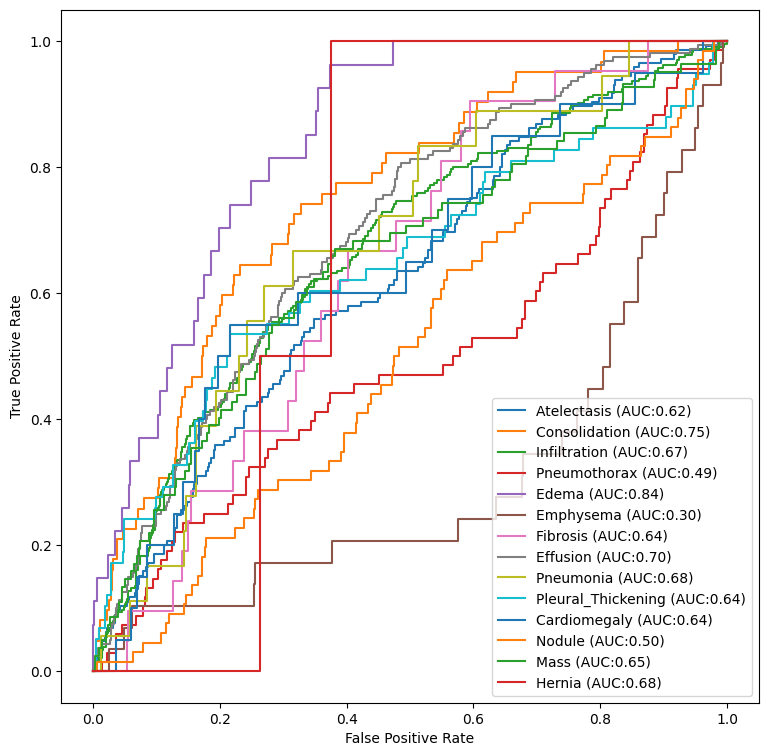

In [276]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_normal += auc(fpr, tpr)
mean_auc_vgg19_normal /= 14
print(mean_auc_vgg19_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [277]:
vgg19_model.load_weights("/kaggle/input/vgg19h5/vgg19.h5")

In [317]:
y_pred_vgg19_process = vgg19_model.predict(test_X_process)
y_pred_vgg19_process[:5]

32/32 [==============================] - 1s 35ms/step


array([[1.68743078e-02, 1.78670194e-02, 2.47276500e-01, 1.16457585e-02,
        2.01909733e-03, 1.39128156e-02, 4.64515854e-03, 1.72485299e-02,
        9.38911643e-03, 1.94541976e-01, 4.62088594e-03, 8.49098936e-02,
        4.44358140e-02, 7.13096652e-03],
       [7.50682829e-03, 7.22187012e-03, 2.01551899e-01, 5.06016845e-03,
        5.55635605e-04, 7.21858535e-03, 2.81671761e-03, 7.86767155e-03,
        4.58946126e-03, 1.88626453e-01, 1.66937488e-03, 7.36924633e-02,
        2.93855071e-02, 4.29325365e-03],
       [4.85839462e-03, 5.20464731e-03, 1.85641304e-01, 3.57633759e-03,
        3.31316522e-04, 5.41427685e-03, 2.06895219e-03, 5.20011224e-03,
        3.21114832e-03, 1.69905752e-01, 1.02370442e-03, 6.47384748e-02,
        2.42089499e-02, 3.13176750e-03],
       [1.45418209e-03, 1.80909561e-03, 1.40860870e-01, 1.16942171e-03,
        6.48440691e-05, 2.12092651e-03, 8.87451868e-04, 1.69136666e-03,
        1.13929133e-03, 1.35882407e-01, 2.37493063e-04, 4.64847907e-02,
        1.350

0.644962835631213


Text(0, 0.5, 'True Positive Rate')

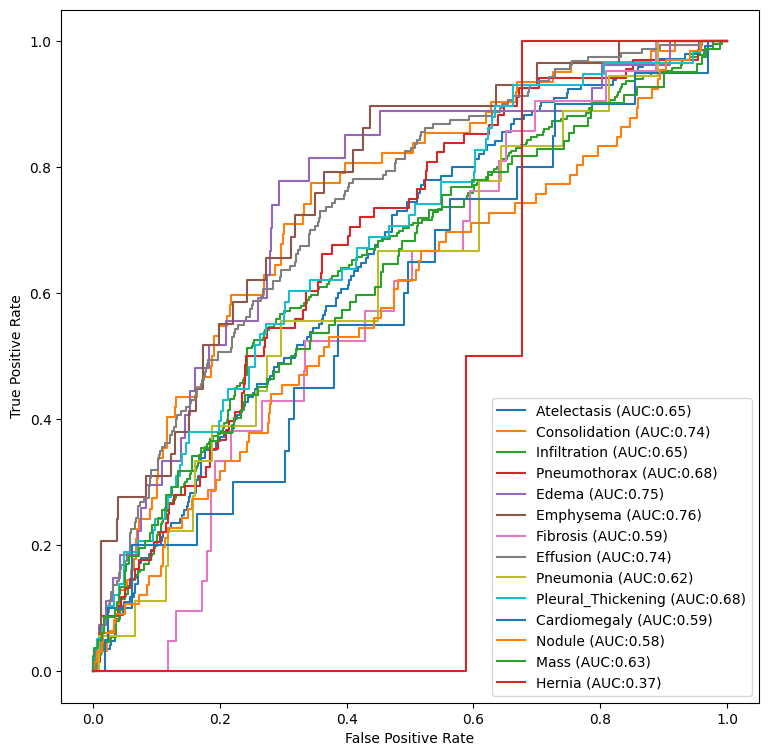

In [319]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_process += auc(fpr, tpr)

mean_auc_vgg19_process /= 14
print(mean_auc_vgg19_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## EfficientNetV2S 

In [280]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

eff = tf.keras.applications.EfficientNetV2S(include_top = False,weights = 'imagenet') 
eff = eff(input)

normal = BatchNormalization() (eff)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

eff_model = tf.keras.Model(inputs=[input], outputs=[output])
eff_model.summary()

82420632/82420632 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 1280)       5120      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               32793

In [281]:
eff_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(0.0001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [282]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch


1000

In [283]:
# eff_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )


### NORMAL

In [287]:
eff_model.load_weights("/kaggle/input/weights/effv2s.h5")

In [288]:
y_pred_eff_normal = eff_model.predict(test_X_normal)
y_pred_eff_normal[:5]


32/32 [==============================] - 2s 66ms/step


array([[0.1610024 , 0.11324459, 0.35542485, 0.1465281 , 0.09709832,
        0.05431557, 0.00791881, 0.22084597, 0.03699698, 0.05372451,
        0.04201161, 0.05719575, 0.0837803 , 0.00227025],
       [0.18455413, 0.0599018 , 0.21583627, 0.11707734, 0.0401912 ,
        0.04503225, 0.01662299, 0.19940604, 0.02315982, 0.06606714,
        0.03514663, 0.06498981, 0.0751089 , 0.00483825],
       [0.18466492, 0.07060239, 0.25089756, 0.12086841, 0.06054387,
        0.05632691, 0.01345607, 0.17272314, 0.02851313, 0.05924014,
        0.03396047, 0.06044917, 0.07686286, 0.00466668],
       [0.06620812, 0.01469566, 0.09587034, 0.05282745, 0.00792032,
        0.03034694, 0.01769796, 0.05735381, 0.00604098, 0.04833214,
        0.00470616, 0.06630895, 0.05119088, 0.0035045 ],
       [0.05620294, 0.01183528, 0.09062512, 0.04893576, 0.00777647,
        0.02244052, 0.00971578, 0.03475539, 0.00486032, 0.03291103,
        0.00431489, 0.05492694, 0.03534548, 0.00152278]], dtype=float32)

0.6880607066811489


Text(0, 0.5, 'True Positive Rate')

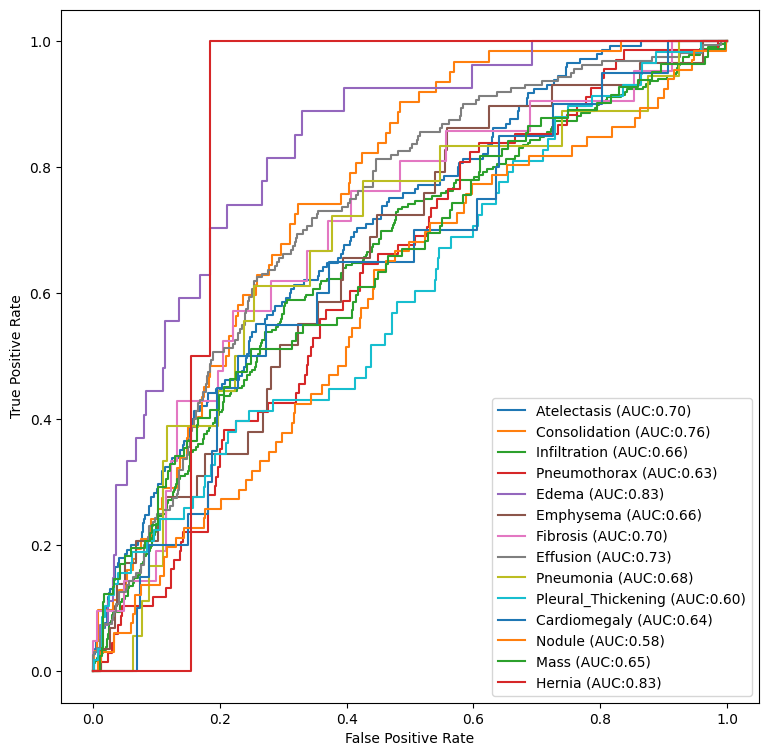

In [290]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_normal = 0
f1_eff_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_normal[:,idx])
    f1_eff_normal += f1_score
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_normal += auc(fpr, tpr)

mean_auc_eff_normal /=14

print(mean_auc_eff_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [291]:
eff_model.load_weights("/kaggle/input/vgg19h5/effv2s_1.h5")

In [293]:
y_pred_eff_process = eff_model.predict(test_X_process)
y_pred_eff_process[:5]


32/32 [==============================] - 3s 99ms/step


array([[0.18941805, 0.07937168, 0.23543558, 0.0450858 , 0.04124153,
        0.02779909, 0.01152279, 0.11980971, 0.0343177 , 0.02747532,
        0.02508792, 0.06790591, 0.04615095, 0.00253636],
       [0.06516274, 0.02457877, 0.17584616, 0.02005578, 0.01078603,
        0.01230688, 0.01116108, 0.03452118, 0.01649517, 0.01599975,
        0.01004202, 0.06805124, 0.03263229, 0.00170954],
       [0.03705868, 0.01382749, 0.15273549, 0.01659371, 0.00546691,
        0.00963549, 0.01281244, 0.01924101, 0.01261765, 0.01437788,
        0.00609313, 0.07909472, 0.03464612, 0.00151656],
       [0.11039484, 0.0444311 , 0.20488383, 0.04613207, 0.01558003,
        0.02844605, 0.02196448, 0.07363919, 0.02848587, 0.02903943,
        0.01694913, 0.09665955, 0.06378996, 0.00267862],
       [0.08804012, 0.04032005, 0.20982553, 0.05276442, 0.0161874 ,
        0.02636262, 0.02077491, 0.0672676 , 0.02832667, 0.0274854 ,
        0.01561401, 0.09785174, 0.06564261, 0.0025399 ]], dtype=float32)

0.6920798830937495


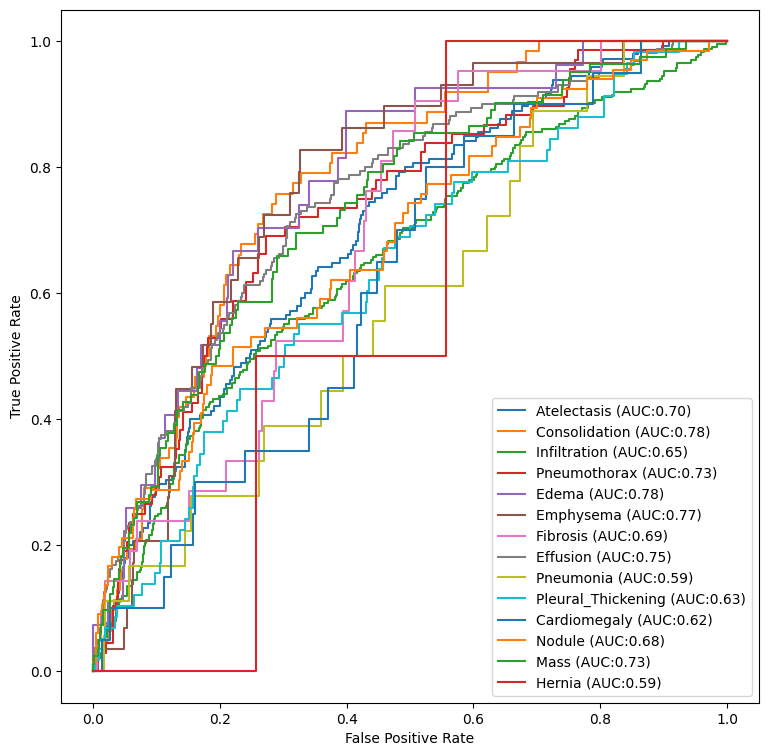

In [294]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_process += auc(fpr, tpr)
    
mean_auc_eff_process /=14
print(mean_auc_eff_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

## ConvNet

In [42]:
import tensorflow_hub as hub

In [43]:
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_base_21k_1k_224_fe/1"

In [44]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32, name = 'input')
input_conv = tf.keras.layers.Resizing(224,224, name = 'resize_input') (input)

hub_layer = hub.KerasLayer(MODEL_PATH, trainable=True, name = "ConvNet")
conv_model = hub_layer (input_conv)

dense1 = Dense(768, activation = tf.keras.activations.gelu, name = "dense_768") (conv_model)
dense1 = Dense(512, activation = tf.keras.activations.gelu, name = "dense_512") (dense1)
dense1 = Dense(128, activation = tf.keras.activations.gelu, name = "dense_128") (dense1)
output = Dense(len(all_labels), activation = 'sigmoid',name = 'output') (dense1)

conv_model = tf.keras.Model(inputs=[input], outputs=[output])
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 resize_input (Resizing)     (None, 224, 224, 3)       0         
                                                                 
 ConvNet (KerasLayer)        (None, 1024)              87566464  
                                                                 
 dense_768 (Dense)           (None, 768)               787200    
                                                                 
 dense_512 (Dense)           (None, 512)               393728    
                                                                 
 dense_128 (Dense)           (None, 128)               65664     
                                                                 
 output (Dense)              (None, 14)                1806

In [45]:
conv_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(3e-5), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [46]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch


1000

In [47]:
# conv_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [110]:
conv_model.load_weights('/kaggle/input/weights/convnet/my_checkpoint')

In [111]:
y_pred_conv_normal = conv_model.predict(test_X_normal)
y_pred_conv_normal[:5]


16/16 [==============================] - 5s 301ms/step


array([[0.03156506, 0.00885874, 0.10979038, 0.00369244, 0.00106808,
        0.00263188, 0.00731213, 0.00679579, 0.00399101, 0.00868826,
        0.00343004, 0.0327522 , 0.01255185, 0.00256084],
       [0.03822843, 0.00944615, 0.16585207, 0.00662692, 0.00095703,
        0.00446943, 0.01219408, 0.01059094, 0.00569598, 0.01184755,
        0.00505347, 0.04311012, 0.01506978, 0.00425617],
       [0.23864914, 0.04460731, 0.2257779 , 0.26987758, 0.01183817,
        0.1397638 , 0.05265085, 0.14752768, 0.02089527, 0.08339093,
        0.00782163, 0.07965637, 0.19913061, 0.01888066],
       [0.26954082, 0.07431047, 0.3190496 , 0.2635711 , 0.02027124,
        0.11364747, 0.03931858, 0.321931  , 0.02774438, 0.1078134 ,
        0.01319808, 0.09853435, 0.22523013, 0.01115679],
       [0.03674674, 0.00969828, 0.15917942, 0.00668097, 0.00105951,
        0.0048007 , 0.01258365, 0.01053964, 0.00580989, 0.01267253,
        0.00456468, 0.04748123, 0.01647002, 0.00446864]], dtype=float32)

0.7560410880031572


Text(0, 0.5, 'True Positive Rate')

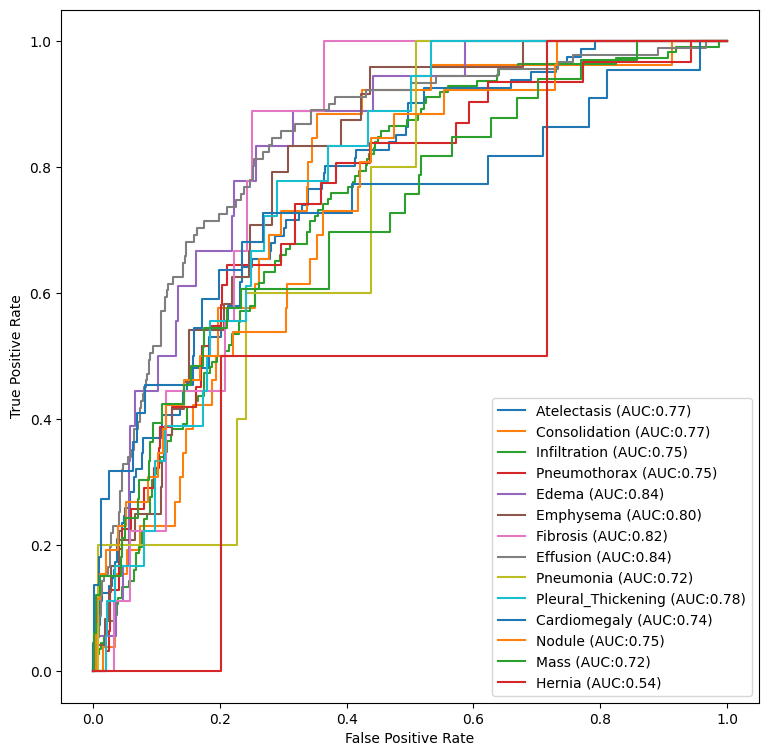

In [112]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_conv_normal += auc(fpr, tpr)

mean_auc_conv_normal /= 14
print(mean_auc_conv_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [113]:
conv_model.load_weights('/kaggle/input/vgg19h5/conv-checkpoint/my_checkpoint')


In [114]:
y_pred_conv_process = conv_model.predict(test_X_process)
y_pred_conv_process[:5]


16/16 [==============================] - 5s 301ms/step


array([[0.02486621, 0.01287154, 0.11386753, 0.00896996, 0.00175923,
        0.008238  , 0.0175266 , 0.02406187, 0.00612316, 0.02270116,
        0.04142703, 0.04173256, 0.01286616, 0.00187038],
       [0.02421338, 0.01478848, 0.13443722, 0.01492251, 0.00319058,
        0.00783705, 0.01816398, 0.02694033, 0.00791639, 0.02992607,
        0.01923467, 0.04954344, 0.01330737, 0.00258428],
       [0.14197169, 0.08810689, 0.14658797, 0.30827293, 0.01364392,
        0.16000572, 0.10491161, 0.23267858, 0.03329368, 0.19314915,
        0.02770876, 0.18218057, 0.26925096, 0.01295164],
       [0.17797099, 0.13061807, 0.34707245, 0.21805072, 0.02497276,
        0.03869757, 0.07089655, 0.63314027, 0.03285343, 0.18062164,
        0.03177994, 0.22672212, 0.22940683, 0.01448145],
       [0.02245374, 0.01445935, 0.12698105, 0.01480865, 0.00329153,
        0.00703854, 0.01421348, 0.01964554, 0.00625023, 0.02956778,
        0.0062678 , 0.0592942 , 0.01369512, 0.00170706]], dtype=float32)

0.7722453765675693


Text(0.5, 1.0, 'AUC for each class')

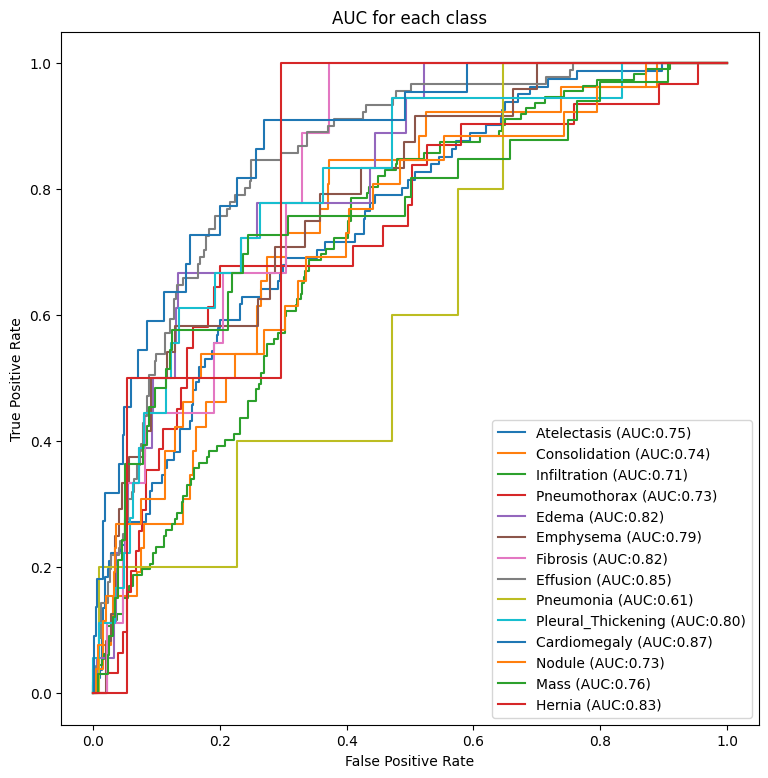

In [116]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_conv_process += auc(fpr, tpr)

mean_auc_conv_process /= 14
print(mean_auc_conv_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title("AUC for each class")